# Two Layer Neural Net
Autor: Gabriel Dornelles Monteiro, março de 2022. Notebook nº3.

Ao fim deste notebook, você deve ser capaz de entender bem o processo de otimização de neural nets em blocos, bem como os cálculos realizados. 

Neste notebook iremos evoluir nosso Softmax Classifier, que possuia apenas 10 neurônios. Para isso iremos adicionar uma nova camada com 1000 neurônios, e introduziremos a função de ativação não linear ReLU.

Também iremos começar a trabalhar em batches para o treinamento, além de tratar o código de uma maneira mais organizada. Ao fim visualizaremos os pesos aprendidos e vamos entender quais foram as melhoras e quais ainda são nossas limitações.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [19]:
# Boilerplate do notebook anterior
train_dataset = CIFAR10(root="./", download=True, train=True) 
val_dataset = CIFAR10(root="./", download=True, train=False) 

train_images = np.array([np.array(train_dataset[i][0]) for i in range(len(train_dataset))])
train_targets = np.array([np.array(train_dataset[i][1]) for i in range(len(train_dataset))])

val_images = np.array([np.array(val_dataset[i][0]) for i in range(len(val_dataset))])
val_targets = np.array([np.array(val_dataset[i][1]) for i in range(len(val_dataset))])

# transforma nossas imagens 32x32x3 em vetor linha 3072
train_images = np.reshape(train_images, (train_images.shape[0], -1))
val_images = np.reshape(val_images, (val_images.shape[0], -1))

# média do array train_images no eixo 0, eixo onde os índices são as imagens 3072
mean_image = np.mean(train_images, axis = 0)

# mean_image é um array de floats, para operação fazer sentido nossas imagens precisam ser também.
train_images = train_images.astype(float)
train_images -= mean_image

val_images = val_images.astype(float)
val_images -= mean_image
# train_images shape: (50000, 3072)

Files already downloaded and verified
Files already downloaded and verified


Temos duas operações diferentes das utilizadas e explicadas no ultimo notebook, o Bias, e a função de ativação ReLU.

## Bias
O bias é uma operação de adição a matriz de pesos (W+b).

O bias nos permite fazer um shift na função de ativação ao adicionar uma constante (vetor de constantes), corrigindo um pouco algumas ativações (deixando mais proximo do output esperado) ou até mesmo possibilitando uma otimização que antes não seria possível devido a natureza do problema.

Um exemplo simples de visualizar é nosso modelo que aprende a função seno.

- Construiremos o mesmo modelo, desta vez com a função de ativação ReLU
- Vejamos os resultados utilizando não utilizando o Bias nas nossas matrizes, e vejamos o resultado com a adição do Bias:


epoch 1/10
epoch 2/10
epoch 3/10
epoch 4/10
epoch 5/10
epoch 6/10
epoch 7/10
epoch 8/10
epoch 9/10
epoch 10/10
Final loss: 0.4864858749508858


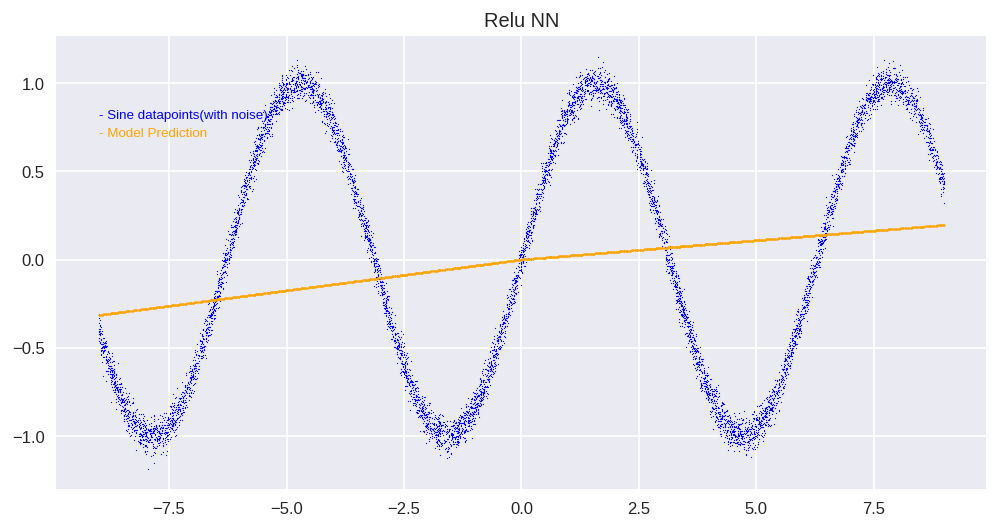

epoch 1/10
epoch 2/10
epoch 3/10
epoch 4/10
epoch 5/10
epoch 6/10
epoch 7/10
epoch 8/10
epoch 9/10
epoch 10/10
Final loss: 0.004536860194057226


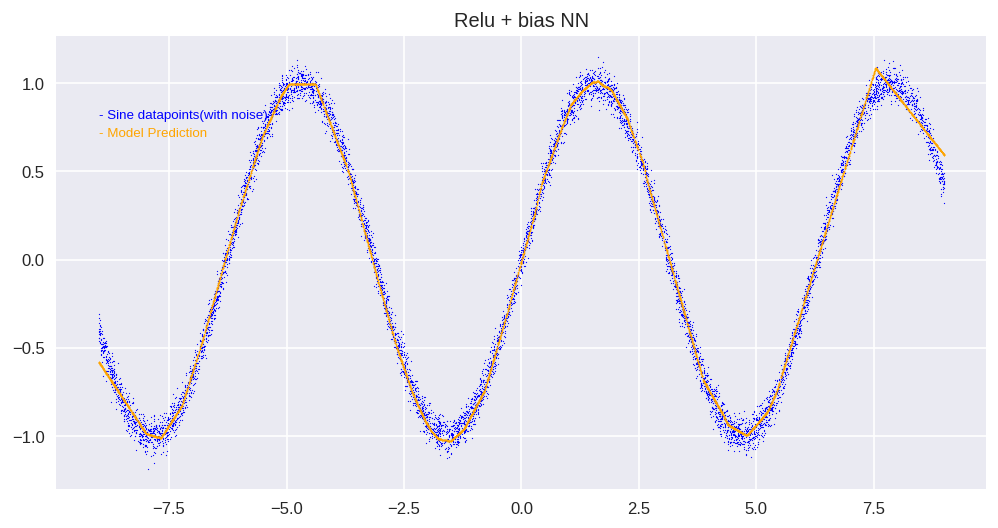

In [17]:
import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim

n_x_train = 30000   # the number of training datapoints
n_x_test = 8000     # the number of testing datapoints

amplitude = 9
x_train = np.random.rand(n_x_train,1)*(amplitude*2) - amplitude  # Initialize a vector of with dimensions [n_x, 1] and extend
y_train = (np.sin(x_train)) # Calculate the sin of all data points in the x vector and reduce amplitude
y_train += (np.random.randn(n_x_train, 1)/20) # add noise to each datapoint

# Repeat data generation for test set
x_test = np.random.rand(n_x_test, 1)*(amplitude*2) - amplitude
y_test = (np.sin(x_test))
y_real = np.sin(x_test)
y_test += (np.random.randn(n_x_test, 1)/20)


class SineDataset(Dataset):
    def __init__(self, x, y):
        x_dtype = torch.FloatTensor
        y_dtype = torch.FloatTensor # for MSE or L1 Loss
        self.length = x.shape[0]
        self.x_data = torch.from_numpy(x).type(x_dtype)
        self.y_data = torch.from_numpy(y).type(y_dtype)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.length

class ShallowLinear(nn.Module):

    def __init__(self, bias=True):
        super(ShallowLinear, self).__init__()
   
        self.activation = nn.ReLU()

        self.linear1 = nn.Linear(1, 16, bias=bias)
        self.linear2 = nn.Linear(16, 16, bias=bias)
        self.linear3 = nn.Linear(16, 16, bias=bias)
        self.linear4 = nn.Linear(16, 1, bias=bias)

    def forward(self, x):
        x = self.activation(self.linear1(x))
        x = self.activation(self.linear2(x))
        x = self.activation(self.linear3(x))
        x = self.linear4(x)
        return x

def run(model, dataset_train, dataset_test):
    # Batch size is the number of training examples used to calculate each iteration's gradient
    batch_size_train = 16
    data_loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size_train, shuffle=True)
    data_loader_test = DataLoader(dataset=dataset_test, batch_size=len(dataset_test), shuffle=False)

    learning_rate = 1e-3
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()  # mean squared error
    epochs = 10
    losses = []
    batch_index = 0
    # Train
    for epoch in range(epochs):
        print(f"epoch {epoch+1}/{epochs}")
        for x, y in data_loader_train:
            y_predict = model(x)
            # Compute loss and do backward pass.
            loss = loss_fn(y_predict, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            losses.append(loss.data.item())
            batch_index += 1
        
    # Test
    y_vectors = []
    y_predict_vectors = []
    batch_index = 0
    for x, y in data_loader_test:
        y_predict = model(x)
        y_vectors.append(y.data.numpy())
        y_predict_vectors.append(y_predict.data.numpy())
        batch_index += 1
    y_predict = np.concatenate(y_predict_vectors)
    

    return model, losses, y_predict


dataset_train = SineDataset(x=x_train, y=y_train)
dataset_test = SineDataset(x=x_test, y=y_test)

for use_bias in [False, True]:
    model = ShallowLinear(bias=use_bias)
    model, losses, y_predict = run(model=model, dataset_train=dataset_train, dataset_test=dataset_test)
    print("Final loss:", sum(losses[-100:])/100)

    plt.figure(figsize=(10, 5), dpi=120)
    plt.style.use('seaborn')
    plt.scatter(x_test, y_test, marker='o', s=0.2, color="blue")
    plt.scatter(x_test, y_predict, marker='o', s=0.3, color="orange")
    plt.text(-9, 0.7, "- Model Prediction", color="orange", fontsize=8)
    plt.text(-9, 0.8, "- Sine datapoints(with noise)", color="blue", fontsize=8)
    plt.title("Relu + bias NN") if use_bias else plt.title("Relu NN")
    plt.show()

Perceba que sem utilizar um Bias nas camadas, nosso modelo não consegue otimizar nossa função, e nos entrega uma função quase linear como resposta (perceba que há uma leve mudança na taxa de crescimento no ponto 0). Ao adicionar o Bias, nossas camadas conseguem ser ajustadas corretamente para entregar uma resposta proxima ao seno real na coordenada.

# Gradientes

## Bias

O gradiente do termo Bias é dado por
$$\frac{∂L}{∂b}=\frac{∂L}{∂W} \frac{∂W}{∂b} $$

Como vimos anteriormente, a derivada local da operação de soma é 1, como estamos operando um array, a derivada local do nosso termo bias é um vetor de 1s.
$$ \frac{∂W}{∂b} = [1,1,1,1,1,...,1] $$


Isso significa que efetivamente, utilizando a regra da cadeia, a operação que realizamos é:

$$\frac{∂L}{∂b}=\frac{∂L}{∂W} * [1,1,1,1,1,...,1] $$

O que é na verdade, já que todos elementos do array são 1, a soma das linhas da matriz W (já que todas serão multiplicadas por 1 e somadas umas as outras). 

Por este motivo, o código que vemos no backward do nosso modelo está assim:
```py
db = dW.sum(axis=0) # Onde dW é o gradiente fluindo no gate da operação resultante de X@W+b
```



## Gradiente da função ReLU
A função ReLU(Rectfied Linear Unit) é dada por:
$$ f(x) = max(0,x) $$

E sua derivada é dada 0 quando x<=0, e 1 quando x>1. Dessa maneira, o gradiente é calculado como:
```py
local_gradient = relu_fc>0 # True para os valores maiores que 0, False para os menores ou iguais a 0
global_gradient = dW # gradiente fluindo de volta para o gate
drelu = global_gradient@local_gradient
```


# Criando nosso modelo
Nosso modelo sera uma rede de duas camadas, formalmente descrevemos como: $$ f(x) = softmax((max(0, X*W1+b1))*(W2+b2))$$

Onde teremos W1, nossa matriz de pesos 3072xN, onde N é o numero de neurônios que desejamos ter (100, 1000 etc), e b1, seu bias.

E W2, nossa matriz Nx10, que irá transformar os neurônios da camada anterior para nossas probabilidades junto a b2, seu bias.

O grafo de nosso modelo fica desta maneira:

### Forward

![image](https://user-images.githubusercontent.com/56324869/183314227-5db1bd3a-af01-4bf6-be19-29c732c7e307.png)


### Backward

![image](https://user-images.githubusercontent.com/56324869/183315137-db252970-f5a4-42f1-880a-9c4508d7c125.png)

In [20]:
class TwoLayerNeuralNet:

    def __init__(self, input_size, hidden_size, output_size, std=1e-4, reg=1.5e-1):
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        self.reg = reg
    
    @staticmethod
    def softmax(scores):
        scores -= np.max(scores, axis=1, keepdims=True)
        scores_exp = np.exp(scores)
        softmax_matrix = scores_exp / np.sum(scores_exp, axis=1, keepdims=True) 
        return softmax_matrix
    
    def val(self, X, y):
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        fc1 = X@W1 + b1 # input to fc
        relu_fc = np.maximum(0, fc1) # fc to relu-fc
        scores = relu_fc@W2 + b2 # relu-fc to output
        softmax = self.softmax(scores) # softmax
        y_pred = np.argmax(softmax, axis=1)
        return (y_pred == y).mean()
    
    def forward(self, X, grad = True):
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
    
        fc = X@W1 + b1 # fully connected
        relu_fc = np.maximum(0, fc) # ReLU
        scores = relu_fc@W2 + b2 # fully connected
        softmax = self.softmax(scores) # softmax

        if grad:
            self.W1, self.W2, self.fc, self.relu_fc = W1, W2, fc, relu_fc

        return softmax

    def loss(self, X, y):
        self.num_train, D = X.shape
        self.softmax_matrix = self.forward(X)
        loss = np.sum(-np.log(self.softmax_matrix[np.arange(self.num_train), y]))
        loss /= self.num_train
        loss += self.reg * (np.sum(self.W2 * self.W2) + np.sum( self.W1 * self.W1 )) # regularization
        return loss
    
    def backward(self, X, y):
        softmax_matrix = self.softmax_matrix
        softmax_matrix[np.arange(self.num_train) ,y] -= 1 
        softmax_matrix /= self.num_train 
        dW2 = (self.relu_fc.T)@(softmax_matrix) #
        db2 = softmax_matrix.sum(axis=0)
        dW1 = (softmax_matrix)@(self.W2.T)   
        dfc = dW1 * (self.fc>0)            
        dW1 = (X.T)@(dfc)            
        db1 = dfc.sum(axis=0) 
        # regularization gradient
        dW1 += self.reg * 2 * self.W1
        dW2 += self.reg * 2 * self.W2
        grads = {'W1':dW1, 'b1':db1, 'W2':dW2, 'b2':db2}
        return grads
    
    def train(self, X, y, X_val, y_val, lr=1e-3, epoches=100, batch_size = 256):
        num_train = X.shape[0]
        loss_history = []
        train_acc_history = []
        val_acc_history = []

        for epoch in range(epoches):
            batch_indices = np.random.choice(num_train, batch_size)
            X_batch = X[batch_indices]
            y_batch = y[batch_indices]
            loss = self.loss(X_batch,y_batch)
            grads = self.backward(X_batch,y_batch)

            # update
            for key in self.params:
                self.params[key] -= lr * grads[key]
            train_acc = self.val(X_batch,y_batch)
            val_acc = self.val(X_val, y_val)

            # save metrics
            loss_history.append(loss)
            train_acc_history.append(train_acc)
            val_acc_history.append(val_acc)

            if epoch%100==0:
                print(f"Epoch {epoch}\n    Loss: {loss}\n    Train acc: {train_acc}\n    Val acc: {val_acc}\n")
        return {
        'loss_history': loss_history,
        'train_acc_history': train_acc_history,
        'val_acc_history': val_acc_history,
        }

In [21]:
model = TwoLayerNeuralNet(input_size=3072, hidden_size=1000, output_size=10)
statistics = model.train(X=train_images, y=train_targets, X_val=val_images, y_val=val_targets, epoches=1000)

Epoch 0
    Loss: 2.307120566944784
    Train acc: 0.2421875
    Val acc: 0.1553

Epoch 100
    Loss: 1.8761706007577028
    Train acc: 0.3203125
    Val acc: 0.3355

Epoch 200
    Loss: 1.687847938712167
    Train acc: 0.40625
    Val acc: 0.4041

Epoch 300
    Loss: 1.5688621995032928
    Train acc: 0.46484375
    Val acc: 0.4323

Epoch 400
    Loss: 1.5439848837370935
    Train acc: 0.47265625
    Val acc: 0.45

Epoch 500
    Loss: 1.4576167772277704
    Train acc: 0.51171875
    Val acc: 0.4528

Epoch 600
    Loss: 1.5461953169763125
    Train acc: 0.58203125
    Val acc: 0.4723

Epoch 700
    Loss: 1.5062485818914684
    Train acc: 0.53515625
    Val acc: 0.4833

Epoch 800
    Loss: 1.4696968005997366
    Train acc: 0.65234375
    Val acc: 0.4798

Epoch 900
    Loss: 1.3414205690570977
    Train acc: 0.65234375
    Val acc: 0.4714



Melhor precisão na validação: 50.250%


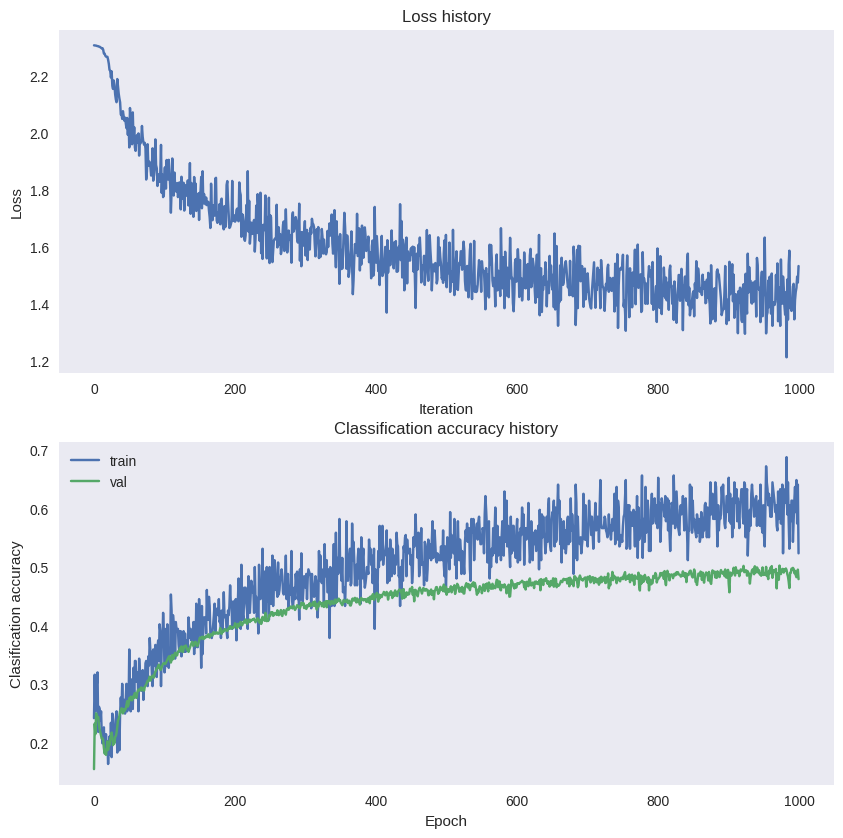

In [22]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

highest_acc = max(statistics['val_acc_history'])
print(f"Melhor precisão na validação: {(highest_acc*100):.3f}%")
figure(figsize=(10,10), dpi=100)

plt.subplot(2, 1, 1)
plt.plot(statistics['loss_history'])
plt.title('Loss history')
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(statistics['train_acc_history'], label='train')
plt.plot(statistics['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()

In [23]:
from math import ceil, sqrt
import numpy as np

def visualize_grid(Xs, ubound=255.0, padding=1):
  """
  Reshape a 4D tensor of image data to a grid for easy visualization.
  Inputs:
  - Xs: Data of shape (N, H, W, C)
  - ubound: Output grid will have values scaled to the range [0, ubound]
  - padding: The number of blank pixels between elements of the grid
  """
  (N, H, W, C) = Xs.shape
  grid_size = int(ceil(sqrt(N)))
  grid_height = H * grid_size + padding * (grid_size - 1)
  grid_width = W * grid_size + padding * (grid_size - 1)
  grid = np.zeros((grid_height, grid_width, C))
  next_idx = 0
  y0, y1 = 0, H
  for y in range(grid_size):
    x0, x1 = 0, W
    for x in range(grid_size):
      if next_idx < N:
        img = Xs[next_idx]
        low, high = np.min(img), np.max(img)
        grid[y0:y1, x0:x1] = ubound * (img - low) / (high - low)
        # grid[y0:y1, x0:x1] = Xs[next_idx]
        next_idx += 1
      x0 += W + padding
      x1 += W + padding
    y0 += H + padding
    y1 += H + padding
  return grid

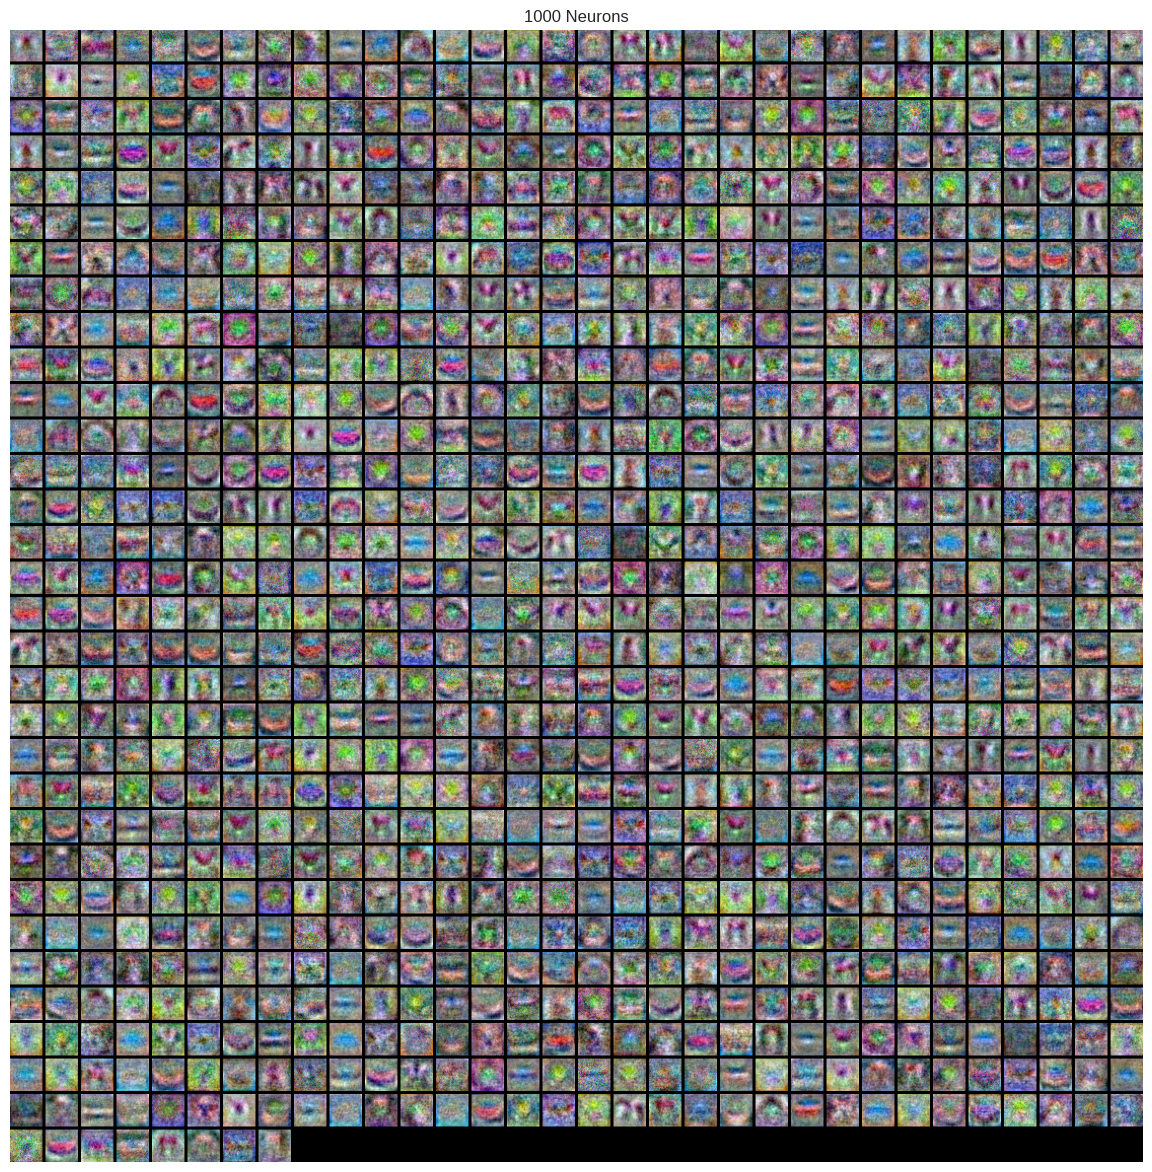

In [24]:
figure(figsize=(15,15), dpi=100)
def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.title("1000 Neurons")
    plt.show()

show_net_weights(model)

In [25]:
# cria um dicionário com o nome das classes e uma lista contendo as imagens associadas no dataset de validação 
empty_lists = [ [] for _ in range(10)]
per_class_images = dict(zip(classes,empty_lists))

for idx, image in enumerate(val_images):
    image_target = classes[val_targets[idx]]
    per_class_images[image_target].append(image)

correct = 0
scores_dict = {}

for idx, class_name in enumerate(classes):
    correct = 0
    for X in per_class_images[class_name]:
        W1, b1 = model.params['W1'], model.params['b1']
        W2, b2 = model.params['W2'], model.params['b2']
    
        fc = X@W1 + b1
        relu_fc = np.maximum(0, fc)
        scores = relu_fc@W2 + b2 
        scores -= np.max(scores, axis=0, keepdims=True)
        scores_exp = np.exp(scores)
        softmax = scores_exp / np.sum(scores_exp, axis=0, keepdims=True) 

        if np.argmax(softmax) == idx:
            correct+=1

    scores_dict.update({class_name: correct/1000})

scores_dict = dict(sorted(scores_dict.items(), key = lambda item: item[1]))
print(scores_dict)

{'cat': 0.217, 'deer': 0.245, 'bird': 0.381, 'plane': 0.518, 'car': 0.523, 'dog': 0.53, 'horse': 0.566, 'frog': 0.569, 'ship': 0.588, 'truck': 0.657}


Abaixo, temos uma tabela realizada para um treinamento anterior. Veja que como nossos batches são aleatórios, algumas classes terão mais templates que outras, fazendo com que em alguns treinamentos tenhamos uma grande diferença de performance em algumas delas, mas mantendo um mesmo nivel de acurácia geral.

Nossas precisões por classe:

| Classe  |  Precisão |  Precisão anterior |  Ganho de precisão|
|---------|---|---|---|
| cat | 0.262  |0.211   | 5.1%
| bird | 0.359  | 0.201  | **15.8%**
| dog | 0.395  | 0.348  |  4.7%
| deer |0.462   | 0.279  | **18.3%**
| plane | 0.495  | 0.492  | 0.3%
| truck | 0.534  | 0.499  | 3.5%
| frog | 0.556  | 0.545  | 1.1%
| horse | 0.568  | 0.388   | **18%**
| car | 0.672  | 0.468  | **20.4%**
| ship | 0.695   | 0.556  | **13.9%**

Para algumas classes, não tivemos ganhos de performance grandes, mas para outras tivemos um ganho grande!

Deer, horse e car foram nossos maiores ganhos, e podemos ver isso presente nos 1000 neurônios pois possuimos neurônios que estão claramente olhando especificamente para um template de uma dessas classes.

Vejamos alguns templates de carro codificados nos neurônios:

![image](https://user-images.githubusercontent.com/56324869/161082267-4a2d216d-d67b-4803-bef7-fd3dca14a149.png)

Vemos agora carros de diferentes cores aparecendo, em diferentes orientações, alguns vistos de um ângulo superior, outros de um ângulo mais baixo.

Agora vejamos alguns de cavalo:

![image](https://user-images.githubusercontent.com/56324869/161081251-05dd85ba-fc19-4be5-87c6-cc44366e83d6.png)

Olhando de perto, vemos no último template algo como um correndo visto cavalo de costas, no penúltimo vemos um cavalo de lado olhando para a esquerda, em outros vemos o cavalo para a direita (ou em ambas direções).

No primeiro template da segunda linha, vemos um homem montando o cavalo, em alguns vemos um cavalo puxado para a cor marrom claro, em outros vemos o cavalo puxado para um tom mais vermelho. Em alguns neurônios percebemos a crina do cavalo, em outros ela não aparece.

Em algumas de nossas classes percebemos que o dataset consegue ser representado e entregaruma boa acurácia dado as generalizações que codificamos em nossos neurônios, como é o caso do cavalo e do carro, com o carro beirando os 70% de precisão, e o cavalo com um grande ganho de 18% comparado ao nosso Softmax classifier com um único neurônio para representa-lo. 

Em outros casos porém, percebemos que não conseguimos aprender efetivamente com as generalizações, com é o caso do gato, que ganhou 5% de precisão e continua com a baixissima precisão de 26%.

Nosso modelo possui agora a capacidade de codificar diferentes posições e cores das classes, como um carro vermelho e um amarelo, e ainda nos entregar com confiabilidade que a imagem é um carro.

Alcançamos uma boa precisão para algumas classes, mas vimos que não será possível para outras, não conseguimos representar nos neurônios os nossos gatos, é muito dificil visualizar nos nossos 1000 neurônios, qualquer um que se pareça com um gato. Isso por que os gatos são muito diferentes, e aparecem em muitas cenas. O mesmo ocorre com os navios e aviões, é dificil visualizar nas imagens com azul (que podem ser tanto o oceano como o céu) se ele é um avião ou um navio, ou mesmo um pássaro.

Pensando em escalar, também já conseguimos intuitivamente ver que precisaremos de muitos neurônios a partir de agora, se quisessemos escalar o que já funciona, e continuariamos com problemas no que não funciona.

Veremos no próximo notebook, como podemos resolver esses problemas, e estaremos molhando os pés na moderna arquitura das redes convolucionais!

**SPOILER**: Aprenderemos a fazer nosso modelo aprender e representar características das classes.
